In [6]:
import random
import cnn_builder as cbuild
import config
import copy
import glob
import importlib
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as reg
import niftiutils.masks as masks
import numpy as np
import os
from os.path import *
import shutil
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_dilation
from skimage.morphology import ball, label

from keras import backend as K
from keras.engine import Input, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import np_utils
%matplotlib inline

In [179]:
importlib.reload(config)
C = config.Config()

img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

## MRI Liver seg

### Data prep

In [4]:
# MRI
for seg in glob.glob(join(target_dir,"*","masks","liver bl.ids")):
    lesion_id = dirname(seg)[len(target_dir)+1:-len("masks")-1]
    if exists(join(C.train_data_dir, lesion_id+"_mri_art.npy")):
        continue
    
    mri_img, mri_dims = hf.nii_load(join(target_dir, lesion_id, "MRI-BL", "t1-art.nii.gz"))
    mask, _ = masks.get_mask(seg, mri_dims, mri_img.shape)

    mri_img -= mri_img.min()
    mri_img /= mri_img.std()
    
    np.save(join(C.train_data_dir, lesion_id+"_mri_art.npy"), mri_img)
    np.save(join(C.train_data_dir, lesion_id+"_mr_bl_liver_mask.npy"), mask > 128)
    
    #mri_img, mri_dims = hf.nii_load(join(target_dir, lesion_id, "MRI-BL", "t1-pre.nii.gz"), True, True)
    #mri_img -= mri_img.min()
    #mri_img /= mri_img.std()
    #np.save(join(C.train_data_dir, lesion_id+"_mri_art.npy"), mri_img)

In [13]:
data_dir = "D:\\JHU\\JHU HCC"

for path in glob.glob(join(data_dir,"*","*.nii")):
    lesion_id = basename(dirname(path))
    lesion_id = lesion_id[:lesion_id.find(" ")]
    
    mri_img, mri_dims = hf.nii_load(path)
    
    mask_paths = glob.glob(join(dirname(path),"*Segs","Liver","*.ids"))
    if len(mask_paths) != 1:
        print(path)
        continue
    mask, _ = masks.get_mask(mask_paths[0], mri_dims, mri_img.shape)

    mri_img -= mri_img.min()
    mri_img /= mri_img.std()
    
    np.save(join(C.train_data_dir, lesion_id+"_mri_art.npy"), mri_img)
    np.save(join(C.train_data_dir, lesion_id+"_mr_bl_liver_mask.npy"), mask > 128)

### Train model

In [ ]:
importlib.reload(cbuild)
model = cbuild.build_unet()
#model.summary(120)

In [ ]:
hist = model.fit_generator(cbuild.train_gen_mri(), epochs=500, steps_per_epoch=5)

In [20]:
model.save(join(C.model_dir, "mri_liver.hdf5"))

### Test

In [72]:
importlib.reload(lm)

<module 'lipiodol_methods' from 'C:\\Users\\Clinton\\Documents\\Lipiodol\\lipiodol_methods.py'>

In [81]:
lesion_id = "12"
mri_nii_path = join(target_dir, lesion_id, "MRI-30d", "t1-art.nii.gz")
save_path = join(target_dir, lesion_id, "masks", "mri_30d_liver")
tumor_mask_path = join(target_dir, lesion_id, "masks", "tumor_30dFU_MRI")
lm.seg_liver_mri_from_path(mri_nii_path, save_path, model, tumor_mask_path)

## CT Liver seg

In [13]:
for fn in glob.glob(join(C.train_data_dir, "*")):
    if fn.endswith("_ct.npy") and (not fn.startswith("PK") and not fn.startswith("BM")):
        os.remove(fn)
        os.remove(fn[:-6]+"mask.npy")

In [21]:
for seg in glob.glob(join(target_dir,"*","masks","wholeliver_24hCT*.ids")):
    lesion_id = dirname(seg)[len(target_dir)+1:-len("masks")-1]
    if exists(join(C.train_data_dir, lesion_id+"_ct.npy")):
        continue
    
    ct_img, ct_dims = hf.nii_load(join(target_dir, lesion_id, "nii_files", "ct24.nii.gz"))
    mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)

    ct_img = tr.apply_window(ct_img)
    ct_img -= np.amin(ct_img)
    
    np.save(join(C.train_data_dir, lesion_id+"_ct.npy"), ct_img)
    np.save(join(C.train_data_dir, lesion_id+"_mask.npy"), mask > mask.max()/2)

In [ ]:
importlib.reload(cbuild)
model = cbuild.build_unet()
model.summary(120)

In [ ]:
hist = model.fit_generator(cbuild.train_gen_ct(), epochs=500, steps_per_epoch=5)

In [6]:
model.save(join(C.model_dir, "ct_liver.hdf5"))

In [107]:
lesion_id = "18"
ct_img, ct_dims = hf.dcm_load(join(target_dir, lesion_id, "CT24h"), True, True)
lm.seg_liver_ct(ct_img, join(target_dir, lesion_id, "ct24_liver"), ct_dims, model)

## Predict Lipiodol concentration

In [ ]:
import pickle
pickle.dump(lesion_crops, "D:\\lesion_crops")

In [ ]:
A = pickle.load("D:\\lesion_crops")

In [267]:
lesion_crops = {}

In [268]:
importlib.reload(lm)
importlib.reload(reg)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    try:
        P = lm.get_paths_dict(lesion_id, target_dir)
    
        art, D = hf.nii_load(P['I']['mrbl']['art'])
        mask, _ = masks.get_mask(P['M']['mrbl']['tumor'], D, art.shape)
        sub = art - hf.nii_load(P['I']['mrbl']['pre'])[0]
        equ = hf.nii_load(join(fn, "MRI-BL", "mribl_equ.nii.gz"))[0]
    except:
        continue
    
    xform_path, crops, pads = reg.get_mask_Tx(P['I']['mrbl']['art'], P['M']['mrbl']['tumor'],
                                          P['I']['ct24'], P['M']['ct24']['tumor'], padding=.3)
    
    art = hf.crop_nonzero(art, crops[1])[0]
    sub = hf.crop_nonzero(sub, crops[1])[0]
    equ = hf.crop_nonzero(equ, crops[1])[0]
    mask = hf.crop_nonzero(mask, crops[1])[0]
    
    reg_ct = reg.transform_region(P['I']['ct24'], xform_path, crops, pads, target_vox_dims=D)#, out_path=reg_ct_path)
    reg_ct = hf.crop_nonzero(reg_ct, crops[1])[0]
    reg_ct[reg_ct < 100] = 100
    reg_ct -= 100
    reg_ct = ((reg_ct-100)/200 + 1)**.5 - 1
    
    np.save(join(C.train_data_dir, lesion_id+"_mrbl_art.npy"), art)
    np.save(join(C.train_data_dir, lesion_id+"_mrbl_sub.npy"), sub)
    #np.save(join(C.train_data_dir, lesion_id+"_mrbl_pv.npy"), pv)
    np.save(join(C.train_data_dir, lesion_id+"_mrbl_equ.npy"), equ)
    np.save(join(C.train_data_dir, lesion_id+"_mrbl_tumor_mask.npy"), mask > mask.max()/2)
    np.save(join(C.train_data_dir, lesion_id+"_lipdensity.npy"), reg_ct)
    
    lesion_crops[lesion_id] = crops[1]

In [ ]:
importlib.reload(cbuild)
model = cbuild.build_unet_multich()
model.summary(120)

In [ ]:
importlib.reload(cbuild)
hist = model.fit_generator(cbuild.train_gen_lip(), epochs=50, steps_per_epoch=10)

In [259]:
lesion_id = "BM-07"

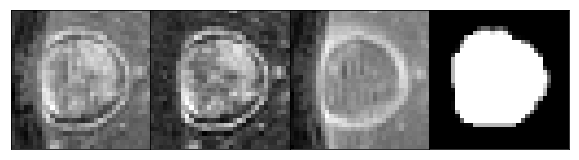

In [260]:
x = np.stack([np.load(join(C.train_data_dir, lesion_id+"_%s.npy" % x)) for x in ["mrbl_art", "mrbl_sub", "mrbl_equ", "mrbl_tumor_mask"]], -1)
x = tr.rescale_img(x, C.small_dims)[0]
x = np.expand_dims(x,0)
hf.draw_slices(x[0,...])

In [269]:
B[0,...,0].min()

0.023331389

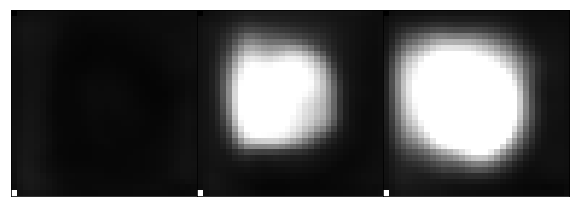

In [266]:
B = model.predict(x)
hf.draw_slices(B[0,...,1], normalize=[0,.7])

In [ ]:
lesion_crops[lesion_id]
out_img = np.pad(out_img, crops_f, 'constant')

In [ ]:
art, D = hf.nii_load(P['I']['mrbl']['art'])
mask, _ = masks.get_mask(P['M']['mrbl']['tumor'], D, art.shape)
sub = art - hf.nii_load(P['I']['mrbl']['pre'])[0]

In [ ]:
masks.save_mask()

In [ ]:
create_dcm_with_mask(img_path, mask_path, save_dir, padding)

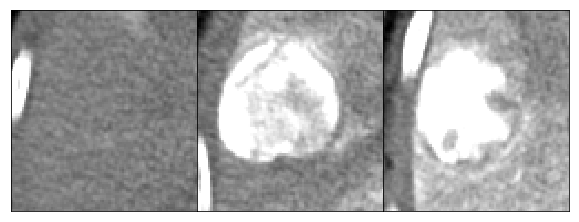

In [262]:
paths = lm.get_paths(lesion_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

CT=masks.crop_img_to_mask_vicinity(ct24_path, ct24_tumor_mask_path,.1)
CT=tr.apply_window(CT)
hf.draw_slices(CT)

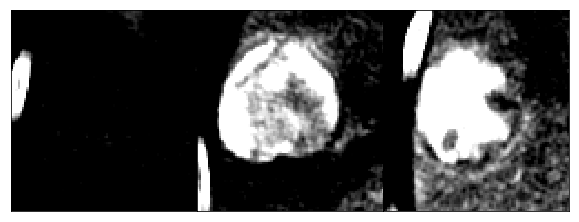

In [263]:
CT[CT < 100] = 100
hf.draw_slices(CT)

# Misc

In [12]:
info = {}

for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        
    seg_liver(ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims)
    break